In [49]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

In [50]:
train_df = pd.read_csv("../data/train.csv")
val_df = pd.read_csv("../data/validation.csv")
test_df = pd.read_csv("../data/test.csv")

In [56]:
tokenizer = Tokenizer()

texts = pd.concat([train_df["Comment_Adj"], val_df["Comment_Adj"], test_df["Comment_Adj"]])
tokenizer.fit_on_texts(texts)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

all_sequences = tokenizer.texts_to_sequences(texts)

maxlen = np.percentile([len(x) for x in all_sequences], 95)  # 95th percentile
print(int(maxlen))

vocab_size = len(tokenizer.word_index) + 1

X_train_sequences = tokenizer.texts_to_sequences(train_df["Comment_Adj"])
X_val_sequences = tokenizer.texts_to_sequences(val_df["Comment_Adj"])

X_train = pad_sequences(X_train_sequences, padding='post', maxlen=87)
X_val = pad_sequences(X_val_sequences, padding='post', maxlen=87)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df["Result_Bin"])
y_val = label_encoder.fit_transform(val_df["Result_Bin"])

87


In [55]:
def set_all_seeds(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_all_seeds(42)

def CNN_model_adj(filter=16, kernel=4, num_1=40, lr=0.01, dropout_rate=0.5):
    set_all_seeds(42)
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=200, 
                               input_length=87))
    model.add(Conv1D(filters=filter, kernel_size=kernel, activation="relu"))
    model.add(MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_1, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


filters = [16, 32, 48]
kernels = [4, 6]
num_1 = [40, 70, 100]
lrs = [0.01, 0.001]
dropout_rate = [0.5, 0.6]

best_accuracy = 0
best_history = None
best_model_desc = ""
best_model_cnn = None

for filter in filters:
    for kernel in kernels:
        for num in num_1:
            for lr in lrs:
                for rate in dropout_rate:
                    model_desc = f"filter = {filter}, kernel = {kernel}, num_1 = {num}, lr = {lr}, dropout_rate = {rate}"
                    print("Training model with configuration:", model_desc)
                    model = CNN_model_adj(filter = filter, kernel = kernel, num_1 = num, lr = lr, dropout_rate = rate)
                    history = model.fit(X_train, y_train,
                    epochs=30,
                    verbose=False,
                    validation_data=(X_val, y_val),
                    batch_size=1000, callbacks = [early_stopping])
                    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=False)
                    print(f"Validation Accuracy: {val_accuracy:.4f}")

                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_history = history
                        best_model_desc = model_desc
                        best_model_cnn = model


print(f"The best model has parameters: {best_model_desc} with accuracy = {round(best_accuracy, 4)}.")

Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.5
Validation Accuracy: 0.5892
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.5975
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6195
Training model with configuration: filter = 16, kernel = 4, num_1 = 40, lr = 0.001, dropout_rate = 0.6
Validation Accuracy: 0.6191
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.5
Validation Accuracy: 0.5975
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.01, dropout_rate = 0.6
Validation Accuracy: 0.6120
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dropout_rate = 0.5
Validation Accuracy: 0.6292
Training model with configuration: filter = 16, kernel = 4, num_1 = 70, lr = 0.001, dro

KeyboardInterrupt: 

In [39]:
best_model_cnn.save('cnn_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

# Load the entire model back
model = load_model('my_cnn_model.h5')

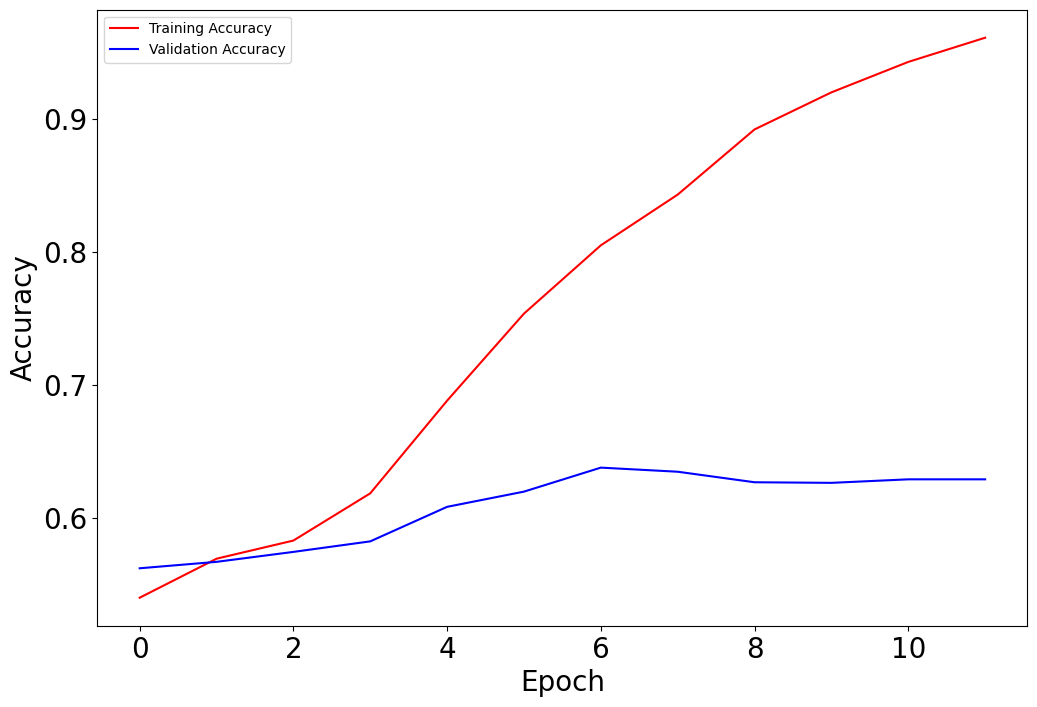

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(best_history.history['accuracy'], 'r', label='Training Accuracy')
ax.plot(best_history.history['val_accuracy'], 'b' ,label='Validation Accuracy')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [24]:
predictions = best_model_cnn.predict(X_val)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_val, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_val, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_val, predictions)
print("Recall:", round(recall, 3))

72/72 [==============================] - 0s 2ms/step
F1 Score: 0.692
Precision: 0.644
Recall: 0.748


<Figure size 800x600 with 0 Axes>

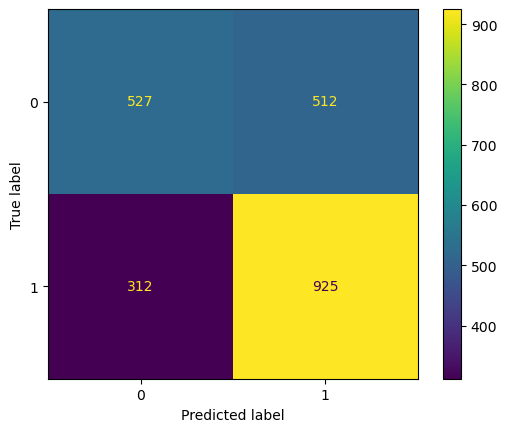

In [25]:
conf_matrix = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()

In [27]:
predictions = best_model_cnn.predict(X_test)
predictions = (predictions > 0.5).astype(int) 

f1 = f1_score(y_test, predictions)
print("F1 Score:", round(f1,3))
# Calculate Precision
precision = precision_score(y_test, predictions)
print("Precision:", round(precision, 3))
# Calculate recall
recall = recall_score(y_test, predictions)
print("Recall:", round(recall, 3))

2024-04-28 23:30:38.827629: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: indices[2,63] = 10780 is not in [0, 10686)
	 [[{{node sequential_119/embedding_119/embedding_lookup}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_119/embedding_119/embedding_lookup' defined at (most recent call last):
    File "/opt/anaconda3/envs/testenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/envs/testenv/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 701, in start
      self.io_loop.start()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell
      await result
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/hs/br_4rpdj68nc3sfdpgv0xgn80000gn/T/ipykernel_77669/3444278365.py", line 1, in <module>
      predictions = best_model_cnn.predict(X_val)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 2111, in predict_step
      return self(x, training=False)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/anaconda3/envs/testenv/lib/python3.9/site-packages/keras/layers/core/embedding.py", line 272, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_119/embedding_119/embedding_lookup'
indices[2,63] = 10780 is not in [0, 10686)
	 [[{{node sequential_119/embedding_119/embedding_lookup}}]] [Op:__inference_predict_function_338434]

<Figure size 800x600 with 0 Axes>

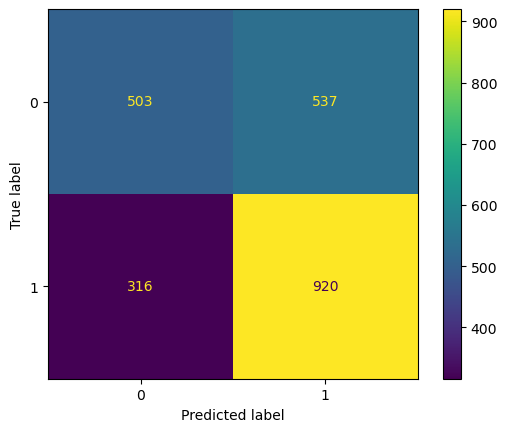

In [12]:
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels = [0,1])
cm_display.plot()